In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathcal{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathcal{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [149]:
y1_grid = np.linspace(1e-10, 4, 50)
y2_grid = np.linspace(1e-10, 4, 50)
# mesh grid and construct state space
(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]

In [150]:
π_p = np.array([3, 0, 0])/3
dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
dΛ2 = γ1 + γ2*y2_mat + π_p@γ3_list*(y2_mat - ȳ)*(y2_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
R_max = 9000
λ = - np.log(0.5)/5
tol = 1e-8
ℓ = 1e-5
ℓ_step = 1e-12

In [151]:
ϵ = 1
episode = 0
lhs_error = 1
while lhs_error > tol:
    if episode ==0:
        v0 =  - δ*η*((y1_mat + y2_mat) + (y1_mat + y2_mat)**2)
    else:
        vold = v0.copy()
    v0_dy1 = derivatives_2d(v0,0,1,hy1)
#     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
    v0_dy2 = derivatives_2d(v0,1,1,hy2)
#     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
    # updating controls

    print(np.min(ems))
#     temp = v0_dy2 + (η-1)*dΛ2
    ems_new =  - δ*η/(v0_dy2*λ*θ)
    ems_new[ems_new <= 0] = 1e-15
    ems = ems_new*1 + ems_old*0
    # HJB coefficient
    A =  -δ*np.ones(y1_mat.shape)
    B_y1 =  y2_mat
    B_y2 = - λ*y2_mat
    C_yy1 = np.zeros(y1_mat.shape)
    C_yy2 = np.zeros(y1_mat.shape)
    D = δ*η*np.log(ems) +  (η-1)*dΛ1*y2_mat - δ*η
    # PDE solver
    solve_start = time.time()
    out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems_old = ems
    print("End of PDE solver, takes time: {}".format(time.time() - solve_start))

1.3087391076287864
Episode 0: PDE Error: 0.085835816723; False Transient Error: 0.118946595890; Iterations: 4661; CG Error: 0.000000000092
End of PDE solver, takes time: 0.12457275390625
228.99089151011808
Episode 1: PDE Error: 0.119646546665; False Transient Error: 0.138637904465; Iterations: 4692; CG Error: 0.000000000092
End of PDE solver, takes time: 0.13010621070861816
25.696012546156446
Episode 2: PDE Error: 0.138879342214; False Transient Error: 0.147772594028; Iterations: 4654; CG Error: 0.000000000096
End of PDE solver, takes time: 0.12438464164733887
12.083515514722166
Episode 3: PDE Error: 0.147921103295; False Transient Error: 0.149721375048; Iterations: 4653; CG Error: 0.000000000088
End of PDE solver, takes time: 0.12406563758850098
7.596967671961449
Episode 4: PDE Error: 0.149825954361; False Transient Error: 0.146769773900; Iterations: 4627; CG Error: 0.000000000096
End of PDE solver, takes time: 0.12337327003479004
5.479076041253312
Episode 5: PDE Error: 0.146848328133

Episode 43: PDE Error: 0.001868195083; False Transient Error: 0.001668992139; Iterations: 4400; CG Error: 0.000000000094
End of PDE solver, takes time: 0.11885690689086914
1.3311927626693176
Episode 44: PDE Error: 0.001669244222; False Transient Error: 0.001494752921; Iterations: 4378; CG Error: 0.000000000084
End of PDE solver, takes time: 0.1183016300201416
1.3301427185300916
Episode 45: PDE Error: 0.001494978485; False Transient Error: 0.001342083259; Iterations: 4376; CG Error: 0.000000000092
End of PDE solver, takes time: 0.11823844909667969
1.3292048421148732
Episode 46: PDE Error: 0.001342282293; False Transient Error: 0.001208218748; Iterations: 4379; CG Error: 0.000000000097
End of PDE solver, takes time: 0.11744046211242676
1.3283647228199293
Episode 47: PDE Error: 0.001208406977; False Transient Error: 0.001090873189; Iterations: 4393; CG Error: 0.000000000091
End of PDE solver, takes time: 0.11860370635986328
1.3276106917017843
Episode 48: PDE Error: 0.001091040750; False T

Episode 86: PDE Error: 0.000206683627; False Transient Error: 0.000206481676; Iterations: 4369; CG Error: 0.000000000091
End of PDE solver, takes time: 0.11783623695373535
1.318059684003233
Episode 87: PDE Error: 0.000206514205; False Transient Error: 0.000196502854; Iterations: 4349; CG Error: 0.000000000090
End of PDE solver, takes time: 0.11691522598266602
1.3179265295238696
Episode 88: PDE Error: 0.000195980769; False Transient Error: 0.000193952401; Iterations: 4306; CG Error: 0.000000000079
End of PDE solver, takes time: 0.11654329299926758
1.317784473934478
Episode 89: PDE Error: 0.000193355092; False Transient Error: 0.000191440749; Iterations: 3852; CG Error: 0.000000000098
End of PDE solver, takes time: 0.1037747859954834
1.3176555525243203
Episode 90: PDE Error: 0.000190856560; False Transient Error: 0.000188966880; Iterations: 4364; CG Error: 0.000000000097
End of PDE solver, takes time: 0.11761999130249023
1.3175373463392905
Episode 91: PDE Error: 0.000188395599; False Tra

Episode 130: PDE Error: 0.000135339348; False Transient Error: 0.000145359859; Iterations: 4269; CG Error: 0.000000000099
End of PDE solver, takes time: 0.11534261703491211
1.3141942972592047
Episode 131: PDE Error: 0.000145378396; False Transient Error: 0.000139672388; Iterations: 3908; CG Error: 0.000000000097
End of PDE solver, takes time: 0.10555124282836914
1.3141179118865116
Episode 132: PDE Error: 0.000139695078; False Transient Error: 0.000123882173; Iterations: 3906; CG Error: 0.000000000099
End of PDE solver, takes time: 0.1060178279876709
1.3140113120907573
Episode 133: PDE Error: 0.000123915303; False Transient Error: 0.000112535488; Iterations: 4305; CG Error: 0.000000000088
End of PDE solver, takes time: 0.11534738540649414
1.313901758111038
Episode 134: PDE Error: 0.000112558156; False Transient Error: 0.000108994315; Iterations: 3910; CG Error: 0.000000000099
End of PDE solver, takes time: 0.10545516014099121
1.3138024599753877
Episode 135: PDE Error: 0.000108758961; Fa

Episode 173: PDE Error: 0.000069257561; False Transient Error: 0.000068571832; Iterations: 2797; CG Error: 0.000000000097
End of PDE solver, takes time: 0.07586669921875
1.3118595630099825
Episode 174: PDE Error: 0.000068453623; False Transient Error: 0.000067775860; Iterations: 2790; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0757131576538086
1.3118780088641468
Episode 175: PDE Error: 0.000067659609; False Transient Error: 0.000066989751; Iterations: 2797; CG Error: 0.000000000097
End of PDE solver, takes time: 0.07549142837524414
1.3118870393122084
Episode 176: PDE Error: 0.000066875382; False Transient Error: 0.000066213266; Iterations: 3828; CG Error: 0.000000000098
End of PDE solver, takes time: 0.1032400131225586
1.3118942707505588
Episode 177: PDE Error: 0.000066100807; False Transient Error: 0.000065446296; Iterations: 3844; CG Error: 0.000000000095
End of PDE solver, takes time: 0.10368037223815918
1.3119299088835605
Episode 178: PDE Error: 0.000065335764; False

Episode 216: PDE Error: 0.000066668624; False Transient Error: 0.000054482554; Iterations: 3796; CG Error: 0.000000000095
End of PDE solver, takes time: 0.1020517349243164
1.3107542470761533
Episode 217: PDE Error: 0.000054500327; False Transient Error: 0.000048072172; Iterations: 4247; CG Error: 0.000000000100
End of PDE solver, takes time: 0.11376047134399414
1.310693812791164
Episode 218: PDE Error: 0.000048078963; False Transient Error: 0.000040850564; Iterations: 3817; CG Error: 0.000000000096
End of PDE solver, takes time: 0.10256814956665039
1.3106426161923594
Episode 219: PDE Error: 0.000040792912; False Transient Error: 0.000040389074; Iterations: 3246; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0871889591217041
1.3105968162857615
Episode 220: PDE Error: 0.000040332233; False Transient Error: 0.000039932910; Iterations: 2588; CG Error: 0.000000000089
End of PDE solver, takes time: 0.06959080696105957
1.3105511942743162
Episode 221: PDE Error: 0.000039876975; Fal

Episode 260: PDE Error: 0.000025706771; False Transient Error: 0.000025452229; Iterations: 3143; CG Error: 0.000000000096
End of PDE solver, takes time: 0.08486199378967285
1.310083186342491
Episode 261: PDE Error: 0.000025421109; False Transient Error: 0.000025169420; Iterations: 2580; CG Error: 0.000000000094
End of PDE solver, takes time: 0.06946158409118652
1.310047739676619
Episode 262: PDE Error: 0.000025138712; False Transient Error: 0.000024889793; Iterations: 2555; CG Error: 0.000000000093
End of PDE solver, takes time: 0.06864237785339355
1.3100112281604597
Episode 263: PDE Error: 0.000024859545; False Transient Error: 0.000024613390; Iterations: 2580; CG Error: 0.000000000087
End of PDE solver, takes time: 0.06990647315979004
1.3099974953245663
Episode 264: PDE Error: 0.000024583567; False Transient Error: 0.000024340181; Iterations: 2581; CG Error: 0.000000000099
End of PDE solver, takes time: 0.06953907012939453
1.3099901311303397
Episode 265: PDE Error: 0.000024310736; Fa

Episode 304: PDE Error: 0.000015770950; False Transient Error: 0.000015614806; Iterations: 2434; CG Error: 0.000000000082
End of PDE solver, takes time: 0.06615471839904785
1.3096227813248327
Episode 305: PDE Error: 0.000015597819; False Transient Error: 0.000015443390; Iterations: 2318; CG Error: 0.000000000086
End of PDE solver, takes time: 0.06258273124694824
1.3096130644961665
Episode 306: PDE Error: 0.000015426627; False Transient Error: 0.000015273904; Iterations: 2318; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0622868537902832
1.3096136455389211
Episode 307: PDE Error: 0.000015257353; False Transient Error: 0.000015106292; Iterations: 2434; CG Error: 0.000000000091
End of PDE solver, takes time: 0.06571292877197266
1.3096145953351495
Episode 308: PDE Error: 0.000015089976; False Transient Error: 0.000014940601; Iterations: 2429; CG Error: 0.000000000094
End of PDE solver, takes time: 0.06592941284179688
1.30961050156404
Episode 309: PDE Error: 0.000014924471; Fal

Episode 349: PDE Error: 0.000011330889; False Transient Error: 0.000009524199; Iterations: 2428; CG Error: 0.000000000097
End of PDE solver, takes time: 0.06560015678405762
1.3094100353719154
Episode 350: PDE Error: 0.000011421612; False Transient Error: 0.000009420650; Iterations: 2578; CG Error: 0.000000000090
End of PDE solver, takes time: 0.06946158409118652
1.3094106055560428
Episode 351: PDE Error: 0.000011511364; False Transient Error: 0.000009318147; Iterations: 2580; CG Error: 0.000000000094
End of PDE solver, takes time: 0.06946682929992676
1.3094184867493266
Episode 352: PDE Error: 0.000011600167; False Transient Error: 0.000009216896; Iterations: 2557; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0692129135131836
1.3094258440299127
Episode 353: PDE Error: 0.000011687998; False Transient Error: 0.000009116673; Iterations: 2777; CG Error: 0.000000000077
End of PDE solver, takes time: 0.07472896575927734
1.3094360688787863
Episode 354: PDE Error: 0.000011774837; F

Episode 394: PDE Error: 0.000018094393; False Transient Error: 0.000010111415; Iterations: 2436; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0660090446472168
1.30929961739318
Episode 395: PDE Error: 0.000014640447; False Transient Error: 0.000007597162; Iterations: 2580; CG Error: 0.000000000098
End of PDE solver, takes time: 0.06954050064086914
1.3092610402567957
Episode 396: PDE Error: 0.000014697170; False Transient Error: 0.000005707940; Iterations: 2430; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0652921199798584
1.3092420736208163
Episode 397: PDE Error: 0.000014753257; False Transient Error: 0.000005646330; Iterations: 2438; CG Error: 0.000000000098
End of PDE solver, takes time: 0.06609463691711426
1.309222609624637
Episode 398: PDE Error: 0.000014808732; False Transient Error: 0.000005585423; Iterations: 2318; CG Error: 0.000000000099
End of PDE solver, takes time: 0.06242537498474121
1.3092139939239524
Episode 399: PDE Error: 0.000014863657; False

Episode 440: PDE Error: 0.000016672719; False Transient Error: 0.000004506705; Iterations: 2439; CG Error: 0.000000000098
End of PDE solver, takes time: 0.06618690490722656
1.3091277138816018
Episode 441: PDE Error: 0.000016707606; False Transient Error: 0.000005666722; Iterations: 2578; CG Error: 0.000000000095
End of PDE solver, takes time: 0.06957006454467773
1.3091272177582631
Episode 442: PDE Error: 0.000016742184; False Transient Error: 0.000006341312; Iterations: 2580; CG Error: 0.000000000088
End of PDE solver, takes time: 0.06949996948242188
1.3091398549128517
Episode 443: PDE Error: 0.000016776335; False Transient Error: 0.000008499542; Iterations: 2588; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0699012279510498
1.3091571094750596
Episode 444: PDE Error: 0.000016810124; False Transient Error: 0.000009505898; Iterations: 2433; CG Error: 0.000000000098
End of PDE solver, takes time: 0.06536436080932617
1.3091674801266637
Episode 445: PDE Error: 0.000016843581; F

Episode 485: PDE Error: 0.000017924933; False Transient Error: 0.000004207747; Iterations: 2318; CG Error: 0.000000000099
End of PDE solver, takes time: 0.06270456314086914
1.3088370946430985
Episode 486: PDE Error: 0.000017946482; False Transient Error: 0.000004204117; Iterations: 2189; CG Error: 0.000000000099
End of PDE solver, takes time: 0.059129953384399414
1.3088393248213737
Episode 487: PDE Error: 0.000017967785; False Transient Error: 0.000006191718; Iterations: 2427; CG Error: 0.000000000096
End of PDE solver, takes time: 0.06538772583007812
1.308839850515162
Episode 488: PDE Error: 0.000017988880; False Transient Error: 0.000006758276; Iterations: 2323; CG Error: 0.000000000093
End of PDE solver, takes time: 0.06257510185241699
1.3088421690649021
Episode 489: PDE Error: 0.000018009697; False Transient Error: 0.000007202582; Iterations: 2428; CG Error: 0.000000000096
End of PDE solver, takes time: 0.06578564643859863
1.3088535341185845
Episode 490: PDE Error: 0.000018030303; 

Episode 530: PDE Error: 0.000018698598; False Transient Error: 0.000002336529; Iterations: 2096; CG Error: 0.000000000098
End of PDE solver, takes time: 0.05682682991027832
1.3088326319955148
Episode 531: PDE Error: 0.000018711944; False Transient Error: 0.000002450244; Iterations: 2100; CG Error: 0.000000000098
End of PDE solver, takes time: 0.056633949279785156
1.3088315621106692
Episode 532: PDE Error: 0.000018725095; False Transient Error: 0.000003197283; Iterations: 2199; CG Error: 0.000000000095
End of PDE solver, takes time: 0.059326887130737305
1.3088298562619642
Episode 533: PDE Error: 0.000018738152; False Transient Error: 0.000004099103; Iterations: 2189; CG Error: 0.000000000097
End of PDE solver, takes time: 0.05912923812866211
1.30882586235859
Episode 534: PDE Error: 0.000018751034; False Transient Error: 0.000005502504; Iterations: 2318; CG Error: 0.000000000096
End of PDE solver, takes time: 0.06279253959655762
1.3088256307763224
Episode 535: PDE Error: 0.000018763783; 

Episode 574: PDE Error: 0.000019169506; False Transient Error: 0.000001843478; Iterations: 1857; CG Error: 0.000000000093
End of PDE solver, takes time: 0.05047321319580078
1.308769525188167
Episode 575: PDE Error: 0.000019177871; False Transient Error: 0.000001989393; Iterations: 1960; CG Error: 0.000000000099
End of PDE solver, takes time: 0.052884817123413086
1.3087688508979296
Episode 576: PDE Error: 0.000019186119; False Transient Error: 0.000001999318; Iterations: 1964; CG Error: 0.000000000099
End of PDE solver, takes time: 0.05302119255065918
1.308765065277244
Episode 577: PDE Error: 0.000019194318; False Transient Error: 0.000001995392; Iterations: 1964; CG Error: 0.000000000098
End of PDE solver, takes time: 0.05298256874084473
1.3087616256342807
Episode 578: PDE Error: 0.000019202445; False Transient Error: 0.000002519157; Iterations: 2094; CG Error: 0.000000000094
End of PDE solver, takes time: 0.056806087493896484
1.308758429453911
Episode 579: PDE Error: 0.000019210460; F

Episode 618: PDE Error: 0.000019465003; False Transient Error: 0.000001551100; Iterations: 1877; CG Error: 0.000000000099
End of PDE solver, takes time: 0.05104827880859375
1.3087466685746771
Episode 619: PDE Error: 0.000019470177; False Transient Error: 0.000001220092; Iterations: 2095; CG Error: 0.000000000097
End of PDE solver, takes time: 0.056496620178222656
1.3087442579462427
Episode 620: PDE Error: 0.000019475430; False Transient Error: 0.000001236050; Iterations: 2065; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0556330680847168
1.308740931595936
Episode 621: PDE Error: 0.000019480579; False Transient Error: 0.000000652394; Iterations: 1641; CG Error: 0.000000000098
End of PDE solver, takes time: 0.04450488090515137
1.3087426179421702
Episode 622: PDE Error: 0.000019485697; False Transient Error: 0.000000509131; Iterations: 1393; CG Error: 0.000000000097
End of PDE solver, takes time: 0.03777265548706055
1.3087462459609096
Episode 623: PDE Error: 0.000019490726; F

Episode 664: PDE Error: 0.000019657309; False Transient Error: 0.000001614366; Iterations: 1784; CG Error: 0.000000000097
End of PDE solver, takes time: 0.04849410057067871
1.3087625562867948
Episode 665: PDE Error: 0.000019660535; False Transient Error: 0.000001352356; Iterations: 1959; CG Error: 0.000000000093
End of PDE solver, takes time: 0.05302619934082031
1.3087595216339578
Episode 666: PDE Error: 0.000019663753; False Transient Error: 0.000001036337; Iterations: 1710; CG Error: 0.000000000099
End of PDE solver, takes time: 0.04614520072937012
1.3087566686924959
Episode 667: PDE Error: 0.000019666884; False Transient Error: 0.000000890485; Iterations: 1781; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0482478141784668
1.3087575804770208
Episode 668: PDE Error: 0.000019670081; False Transient Error: 0.000000750421; Iterations: 1393; CG Error: 0.000000000099
End of PDE solver, takes time: 0.037854909896850586
1.3087593433307807
Episode 669: PDE Error: 0.000019673193; 

Episode 707: PDE Error: 0.000019770059; False Transient Error: 0.000000422422; Iterations: 923; CG Error: 0.000000000095
End of PDE solver, takes time: 0.025566816329956055
1.3087609288421063
Episode 708: PDE Error: 0.000019772110; False Transient Error: 0.000000453396; Iterations: 924; CG Error: 0.000000000095
End of PDE solver, takes time: 0.025408029556274414
1.3087608853167667
Episode 709: PDE Error: 0.000019774131; False Transient Error: 0.000000518154; Iterations: 995; CG Error: 0.000000000098
End of PDE solver, takes time: 0.02718520164489746
1.308760836382816
Episode 710: PDE Error: 0.000019776154; False Transient Error: 0.000000582706; Iterations: 1039; CG Error: 0.000000000099
End of PDE solver, takes time: 0.028405427932739258
1.3087607383853088
Episode 711: PDE Error: 0.000019778157; False Transient Error: 0.000000671204; Iterations: 1090; CG Error: 0.000000000098
End of PDE solver, takes time: 0.029651880264282227
1.3087605999367846
Episode 712: PDE Error: 0.000019780161; 

Episode 752: PDE Error: 0.000019844514; False Transient Error: 0.000002465983; Iterations: 1802; CG Error: 0.000000000091
End of PDE solver, takes time: 0.048891305923461914
1.308757344386577
Episode 753: PDE Error: 0.000019845774; False Transient Error: 0.000001703395; Iterations: 1997; CG Error: 0.000000000100
End of PDE solver, takes time: 0.05399513244628906
1.308755715949674
Episode 754: PDE Error: 0.000019847030; False Transient Error: 0.000001619786; Iterations: 1786; CG Error: 0.000000000097
End of PDE solver, takes time: 0.048233747482299805
1.3087507984006816
Episode 755: PDE Error: 0.000019848274; False Transient Error: 0.000001198655; Iterations: 1712; CG Error: 0.000000000094
End of PDE solver, takes time: 0.04633688926696777
1.3087471588735884
Episode 756: PDE Error: 0.000019849545; False Transient Error: 0.000000969600; Iterations: 1601; CG Error: 0.000000000096
End of PDE solver, takes time: 0.04337024688720703
1.3087460202496606
Episode 757: PDE Error: 0.000019850755; 

Episode 802: PDE Error: 0.000019895016; False Transient Error: 0.000000558621; Iterations: 888; CG Error: 0.000000000096
End of PDE solver, takes time: 0.024658679962158203
1.3087460427373612
Episode 803: PDE Error: 0.000019895825; False Transient Error: 0.000000564109; Iterations: 885; CG Error: 0.000000000099
End of PDE solver, takes time: 0.02436232566833496
1.3087459033120696
Episode 804: PDE Error: 0.000019896598; False Transient Error: 0.000000572599; Iterations: 930; CG Error: 0.000000000100
End of PDE solver, takes time: 0.025464534759521484
1.3087461366159236
Episode 805: PDE Error: 0.000019897336; False Transient Error: 0.000000543702; Iterations: 1251; CG Error: 0.000000000098
End of PDE solver, takes time: 0.03416943550109863
1.3087464538816351
Episode 806: PDE Error: 0.000019898078; False Transient Error: 0.000000635539; Iterations: 892; CG Error: 0.000000000100
End of PDE solver, takes time: 0.02447342872619629
1.3087465384252013
Episode 807: PDE Error: 0.000019898822; Fa

Episode 871: PDE Error: 0.000019931887; False Transient Error: 0.000000269680; Iterations: 774; CG Error: 0.000000000097
End of PDE solver, takes time: 0.021929025650024414
1.3087462306226263
Episode 872: PDE Error: 0.000019932142; False Transient Error: 0.000000262468; Iterations: 814; CG Error: 0.000000000093
End of PDE solver, takes time: 0.022455453872680664
1.3087462960292886
Episode 873: PDE Error: 0.000019932332; False Transient Error: 0.000000256871; Iterations: 815; CG Error: 0.000000000098
End of PDE solver, takes time: 0.022337675094604492
1.3087463653905738
Episode 874: PDE Error: 0.000019932562; False Transient Error: 0.000000272434; Iterations: 876; CG Error: 0.000000000093
End of PDE solver, takes time: 0.023947954177856445
1.308746442185566
Episode 875: PDE Error: 0.000019932791; False Transient Error: 0.000000284455; Iterations: 877; CG Error: 0.000000000097
End of PDE solver, takes time: 0.02410745620727539
1.3087465798164506
Episode 876: PDE Error: 0.000019933143; Fa

1.308739120190498
Episode 982: PDE Error: 0.000019957259; False Transient Error: 0.000000011645; Iterations: 24; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0012362003326416016
1.3087391194386069
Episode 983: PDE Error: 0.000019957369; False Transient Error: 0.000000011516; Iterations: 24; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0012347698211669922
1.3087391186881356
Episode 984: PDE Error: 0.000019957486; False Transient Error: 0.000000011613; Iterations: 25; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0012679100036621094
1.3087391179399042
Episode 985: PDE Error: 0.000019957643; False Transient Error: 0.000000011481; Iterations: 25; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0012598037719726562
1.308739117148614
Episode 986: PDE Error: 0.000019957846; False Transient Error: 0.000000011666; Iterations: 22; CG Error: 0.000000000098
End of PDE solver, takes time: 0.001188039779663086
1.3087391163539792
Episode 987: PDE Error: 

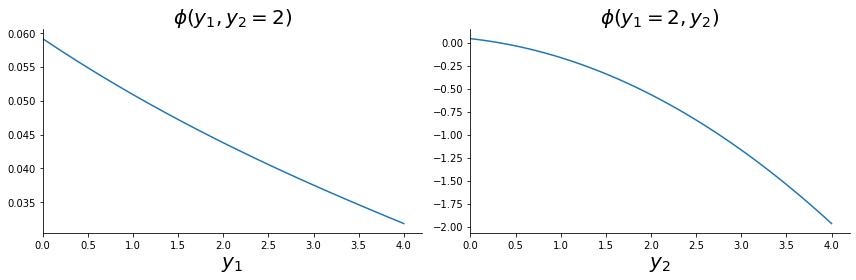

In [137]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], v0[:,0])
ax1.set_title('$ϕ(y_1, y_2 = 2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[25])
ax2.set_title('$ϕ(y_1 = 2, y_2)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")

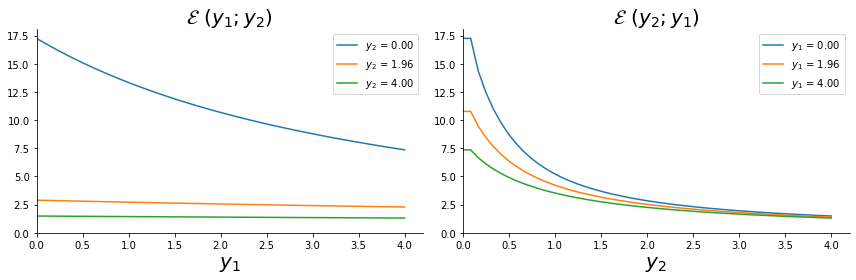

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], ems[:,24], label="$y_2$ = {:.2f}".format(y2_mat[0,24]))
ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[24], ems[24], label="$y_1$ = {:.2f}".format(y1_mat[24,0]))
ax2.plot(y2_mat[-1], ems[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [146]:
ems[0]

array([17.25316528, 17.25316528, 14.37845052, 12.49615294, 11.01493985,
        9.80650835,  8.8039785 ,  7.96349669,  7.25330524,  6.64903913,
        6.13138202,  5.68479324,  5.29672492,  4.95705927,  4.65765441,
        4.39196111,  4.15470083,  3.94160114,  3.74918325,  3.57459462,
        3.41547843,  3.26987251,  3.13613108,  3.01286401,  2.89888945,
        2.79319651,  2.69491567,  2.60329507,  2.51768127,  2.43750375,
        2.36226206,  2.29151535,  2.22487371,  2.16199099,  2.10255875,
        2.04630125,  1.99297122,  1.9423462 ,  1.89422559,  1.848428  ,
        1.80478907,  1.76315957,  1.72340369,  1.68539761,  1.64902821,
        1.61419194,  1.58079386,  1.54874671,  1.51797022,  1.48839039])

In [147]:
v0_dy2

array([[-0.07185514, -0.07185514, -0.0862213 , ..., -0.80047217,
        -0.81670156, -0.83293244],
       [-0.07349862, -0.07349862, -0.08792746, ..., -0.80280514,
        -0.81903468, -0.83526572],
       [-0.0751571 , -0.0751571 , -0.08964855, ..., -0.80513811,
        -0.82136782, -0.83759901],
       ...,
       [-0.16375569, -0.16375569, -0.18127734, ..., -0.91012984,
        -0.92636571, -0.94260258],
       [-0.16607346, -0.16607346, -0.18359472, ..., -0.9124631 ,
        -0.92869906, -0.94493604],
       [-0.16841288, -0.16841288, -0.18591471, ..., -0.91479635,
        -0.93103241, -0.94726951]])